# Tutorial 5: Liver Metastasis Domain Detection with GLAND (Expression Reconstruction)
This notebook demonstrates the workflow of using GLAND for gene expression enhancement.

## Environment Configuration


In [1]:
#First, we import the necessary libraries and configure the computation device. We also set the R_HOME environment variable to ensure mclust (required for clustering) functions correctly within the Python environment.
import os
import torch
import pandas as pd
import scanpy as sc
from sklearn import metrics
from sklearn.metrics import normalized_mutual_info_score
from GLAND import GLAND
from GLAND.utils import clustering

# Set computation device (GPU is highly recommended for GLAND training)
device = torch.device('cuda:3' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Configure R environment for mclust algorithm
# Path mapped to your conda environment
os.environ['R_HOME'] =r'your R'

Using device: cuda:3


## Data Loading and Preprocessing

In [2]:
adata = sc.read_h5ad("/mnt/first19T/liufk/x/colon_and_liver/all/ST-liver2.h5ad")
adata.var_names_make_unique()
n_clusters = len(adata.obs['ground_truth'].cat.categories.tolist())

## Model Training and Spatial Clustering

/mnt/first19T/liufk/anaconda3/envs/GraphST-main/lib/python3.8/site-packages/scanpy/preprocessing/_highly_variable_genes.py:64: UserWarning: `flavor='seurat_v3'` expects raw count data, but non-integers were found.
  warnings.warn(


Total number of points before filtering: 4658

Filtering using a fixed threshold: 1.8

Total number of points after filtering: 4621
Number of points filtered out: 37


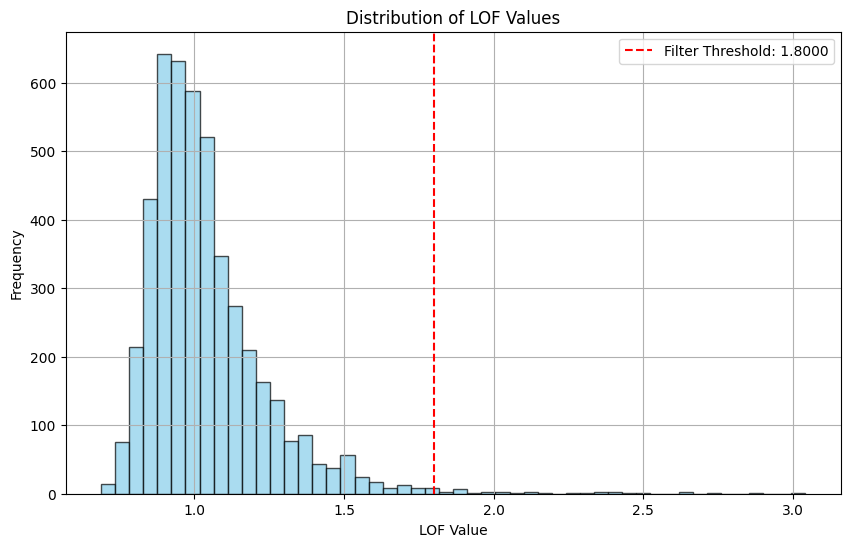

/mnt/first19T/liufk/GLAND/preprocess.py:115: RuntimeWarning: divide by zero encountered in power
  d_inv_sqrt = np.power(rowsum, -0.5).flatten()


Begin to train ST data...


 50%|████████████████████████████████▌                                | 200/400 [00:27<00:27,  7.29it/s]

Updating adjacency matrix at epoch 200...


100%|█████████████████████████████████████████████████████████████████| 400/400 [00:57<00:00,  6.93it/s]


Optimization finished for ST data!


by .GlobalEnv when processing object ‘.pbd_env’
R[write to console]:                    __           __ 
   ____ ___  _____/ /_  _______/ /_
  / __ `__ \/ ___/ / / / / ___/ __/
 / / / / / / /__/ / /_/ (__  ) /_  
/_/ /_/ /_/\___/_/\__,_/____/\__/   version 6.1.1
Type 'citation("mclust")' for citing this R package in publications.



fitting ...
  |======================================================================| 100%


In [3]:
model = GLAND.GLAND(adata, device=device, epochs=400, n_clusters=n_clusters, lofk=13)
adata = model.train()
radius=50
tool = 'mclust' # mclust, leiden, and louvain

# clustering
if tool == 'mclust':
   clustering(adata, n_clusters, radius=radius, method=tool, refinement=False) # For DLPFC dataset, we use optional refinement step.
elif tool in ['leiden', 'louvain']:
   clustering(adata, n_clusters, radius=radius, method=tool, start=0.1, end=2.0, increment=0.01, refinement=False)

## Evaluation and Visualization

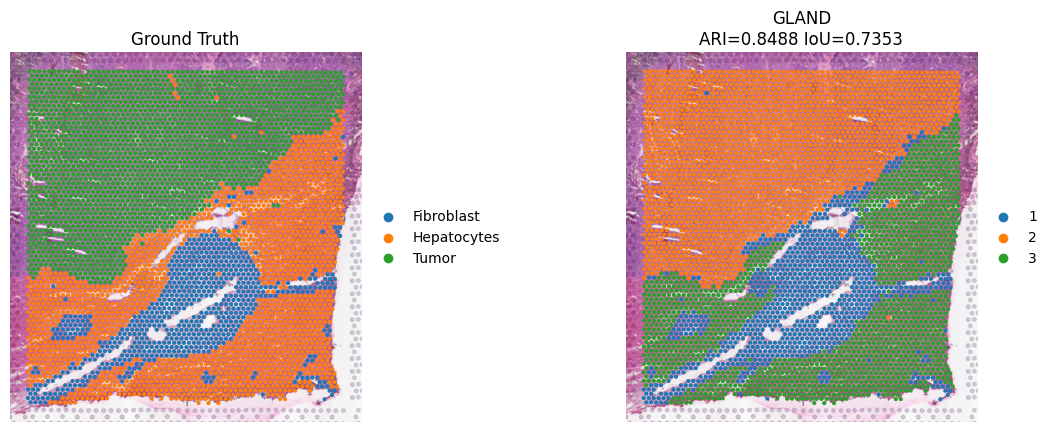

In [4]:
#Since unsupervised clustering labels (e.g., cluster 1, 2, 3) do not inherently match biological labels (e.g., Portal, Mid), we use a permutation approach to find the best label mapping that maximizes the overlap for specific tissue structures.
import numpy as np
import pandas as pd
import scanpy as sc
from itertools import permutations
from sklearn import metrics
from sklearn.metrics import normalized_mutual_info_score

mask = adata.obs['ground_truth'].notna() & adata.obs['domain'].notna()
adata = adata[mask].copy()

def get_metrics(mapping, adata):
    """Calculate IoU for all labels based on a mapping."""
    gt = adata.obs['ground_truth'].map(mapping)
    dt = adata.obs['domain'].astype(int)
    
    res = {}
    for label, cluster_id in mapping.items():
        inter = np.sum((gt == cluster_id) & (dt == cluster_id))
        union = np.sum((gt == cluster_id) | (dt == cluster_id))
        res[label] = inter / union if union > 0 else 0
    return res

target_labels = adata.obs['ground_truth'].unique().tolist()
target_labels = [str(l) for l in target_labels if pd.notna(l)]
cluster_ids = range(1, len(target_labels) + 1)

best_iou_scores = max(
    (get_metrics(dict(zip(target_labels, p)), adata) for p in permutations(cluster_ids)),
    key=lambda x: x.get("Fibroblast", 0)
)

ari = metrics.adjusted_rand_score(adata.obs['domain'], adata.obs['ground_truth'])

adata.uns.update({'IoU_Scores': best_iou_scores, 'ARI': ari})

iou = best_iou_scores.get("Fibroblast", 0)
sc.pl.spatial(
    adata, color=["ground_truth", "domain"], spot_size=6, frameon=False,
    title=["Ground Truth", f"GLAND\nARI={ari:.4f} IoU={iou:.4f}"]
)

## Expression Enhancement

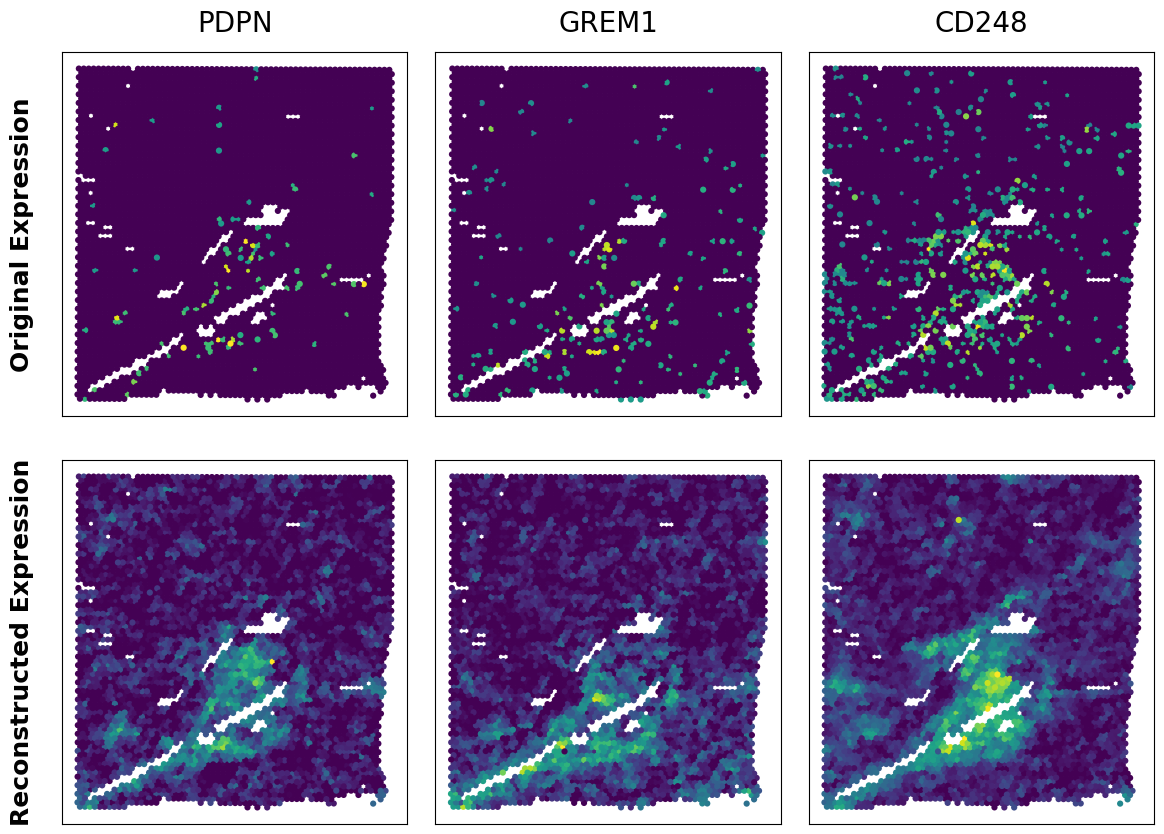

In [6]:
# Compare original gene expression with reconstructed expression in spatial coordinates
import scanpy as sc
import matplotlib.pyplot as plt
import numpy as np

genes_to_plot = ['PDPN', 'GREM1', 'CD248']
recon_key = 'reconstructed'
coords = adata.obsm['spatial']

# Initialize figure
n_genes = len(genes_to_plot)
fig, axes = plt.subplots(2, n_genes, figsize=(n_genes * 4, 9), squeeze=False)

for i, gene in enumerate(genes_to_plot):
    # Get original expression (handling sparse matrix if necessary)
    orig_exp = adata[:, gene].X.toarray().flatten() if hasattr(adata[:, gene].X, 'toarray') else adata[:, gene].X.flatten()
    # Get reconstructed expression from specified layer
    recon_exp = adata[:, gene].layers[recon_key].flatten()
    
    for row, expression in enumerate([orig_exp, recon_exp]):
        ax = axes[row, i]
        # Plot spatial scatter
        ax.scatter(coords[:, 0], coords[:, 1], s=20, c=expression, cmap='viridis', vmin=0, edgecolors='none')
        
        # Formatting
        ax.set_aspect('equal')
        ax.invert_yaxis()
        ax.set_xticks([]); ax.set_yticks([]) 
        if row == 0: 
            ax.set_title(gene, fontsize=20, pad=15)

# Set row labels
axes[0, 0].set_ylabel('Original Expression', fontsize=18, weight='bold', labelpad=20)
axes[1, 0].set_ylabel('Reconstructed Expression', fontsize=18, weight='bold', labelpad=20)

plt.tight_layout(pad=2.0)
plt.show()